In [1]:
import datetime

import matplotlib
import numpy as np
import random
import sqlalchemy
import pandas as pd
import seaborn as sns
sns.set_context('poster')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlalchemy.create_engine('sqlite:////home/aahu/Dropbox/ryancompton.net/assets/reddit_scrape/scores.db')
conn.connect()
df = pd.read_sql('''SELECT created_utc, fetch_time, score, subreddit, domain, title, ups, id, link_flair_text
                           FROM submissions''', conn)

In [3]:
import dateutil.parser
dateutil.parser.parse(df['fetch_time'].iloc[0])

datetime.datetime(2016, 8, 5, 1, 24, 47, 639375)

In [4]:
df['created_datetime'] = df['created_utc'].map(datetime.datetime.fromtimestamp)
df['age'] = (df['fetch_time'].map(dateutil.parser.parse) - df['created_datetime'])#.map(pd.to_timedelta)
df['age_hours'] = df['age'].map(lambda x:x.seconds/(60*60))

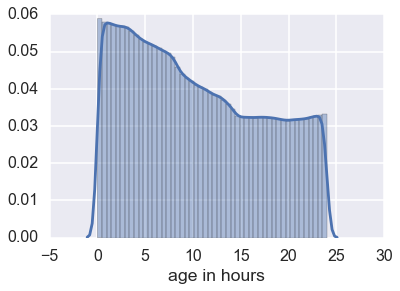

In [5]:
sns.distplot(df['age'].map(lambda x:x.seconds/(60*60)), norm_hist=False)
plt.xlabel('age in hours')

In [6]:
df.columns

Index(['created_utc', 'fetch_time', 'score', 'subreddit', 'domain', 'title',
       'ups', 'id', 'link_flair_text', 'created_datetime', 'age', 'age_hours'],
      dtype='object')

In [7]:
#df.groupby('id')[['age','score']].count()
df = df.groupby('id').filter(lambda x: len(x) > 1)

In [8]:
df['subreddit'].value_counts()

The_Donald             333871
politics               330532
worldnews              311994
PoliticalDiscussion    311100
hillaryclinton         228906
4chan                  227869
EnoughTrumpSpam        227647
pics                   216511
funny                  198392
DNCleaks               186217
WikiLeaks              125159
news                    93246
Conservative            42390
Name: subreddit, dtype: int64

In [9]:
#df = df[df['subreddit'] == 'The_Donald']
dfp = df.groupby('id').filter(lambda x: (50 < max(x['score']) < 50000) 
                              #and (min(x['age_hours']) < 1) 
                             and (min(x['score'])<10))
dfp['rev_id'] = dfp['id'].map(lambda x:x[::-1]) #group by reversed id to shuffle plot order

import hashlib
dfp['hash_id'] = dfp['id'].map(lambda x:int(hashlib.md5(x.encode('utf-8')).hexdigest(),16)%123456789) #group by reversed id to shuffle plot order

dfp.shape

/home/aahu/.virtualenvs/rs/local/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/aahu/.virtualenvs/rs/local/lib/python3.4/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(154160, 14)

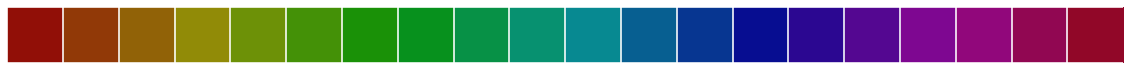

In [10]:
colors = sns.hls_palette(20, l=.3, s=.9)
sns.palplot(colors)

In [11]:
mycmap = {'4chan': (0.05249999999999999, 0.6475, 0.088200000000000028),
 'DNCleaks': (0.49279999999999979, 0.6475, 0.05249999999999999),
 'EnoughTrumpSpam': (0.6475, 0.32619999999999993, 0.05249999999999999),
 'PoliticalDiscussion': (0.56419999999999992, 0.05249999999999999, 0.6475),
 'The_Donald': '#FF0000',
 'WikiLeaks': (0.6475, 0.088199999999999987, 0.05249999999999999),
 'funny': (0.088200000000000028, 0.05249999999999999, 0.6475),
 'hillaryclinton': (0.05249999999999999, 0.6475, 0.32620000000000016),
 'news': (0.6475, 0.05249999999999999, 0.25479999999999947),
 'pics': (0.05249999999999999, 0.49279999999999979, 0.6475),
 'politics': (0.25479999999999992, 0.6475, 0.05249999999999999),
 'worldnews': (0.32619999999999993, 0.05249999999999999, 0.6475)}

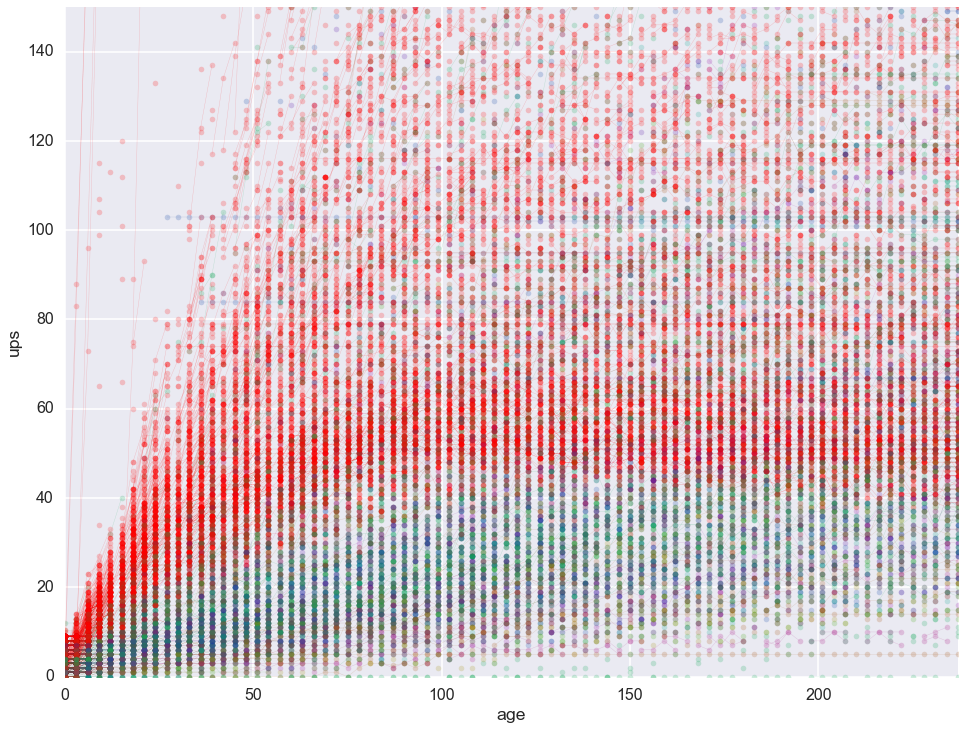

In [12]:
fig = plt.figure(figsize=(16,12))
mycmap = {}
mycmap['The_Donald'] = '#FF0000'
colors = sns.hls_palette(15, l=.35, s=.85)
random.shuffle(colors)
colidx = 0
xcol = 'age'
ycol = 'ups'
dics = []
gps = []
n_hours = 4
idx = pd.to_timedelta(range(0,60*n_hours,3), unit='m')
for name, group in dfp.groupby('hash_id'):
    gp = group[[xcol, ycol]]
    gp = gp[gp[xcol] < pd.Timedelta('{} hours'.format(n_hours))]
    gp = gp.set_index(xcol)
    gp['total_mins'] = gp.index.map(lambda x:x.total_seconds()/60)
    gp1 = gp.copy()
    gp = gp.resample('3T').mean()
    gp = gp.reindex(idx,method='nearest')
    gps.append(gp)
    #gp = gp.fillna(method='pad')
    gp.index = gp.index.map(lambda x:int(x.total_seconds()/60))
    gp.sort_index(inplace=True)
    if len(gp) > 1:
        lbl = group['subreddit'].iloc[0]
        #lbl = group['title'].iloc[0]
        if lbl not in mycmap.keys():
            #mycmap[lbl] = random.choice(list(matplotlib.colors.cnames.keys()))
            mycmap[lbl] = colors[colidx]
            colidx+=1
        gp[ycol].plot(alpha=.2, marker='.',linewidth=.4, label=lbl, color = mycmap[lbl])
        dic = {'subreddit': group['subreddit'].iloc[0],
               'domain': group['subreddit'].iloc[0],
               'id':group['id'].iloc[0],
               'scores':gp,
               'ts_scores':gp1,
               'color':mycmap[lbl]}
        dics.append(dic)
plt.ylim([0,150])
plt.xlabel(xcol)
plt.ylabel(ycol)

In [13]:
subreddits = ['worldnews', 'news', 'politics', 'The_Donald',
       'PoliticalDiscussion', 'WikiLeaks', 'DNCleaks', '4chan', 'pics',
       'funny', 'hillaryclinton', 'Conservative']

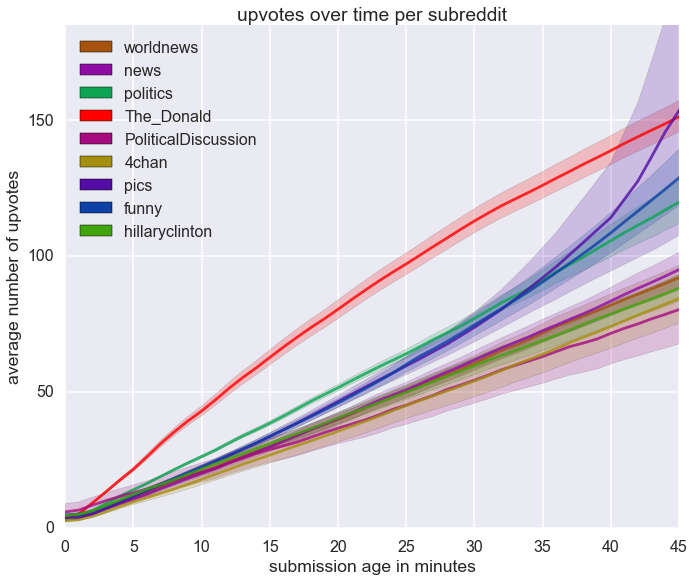

In [14]:
#with plt.xkcd():
fig,ax = plt.subplots(1,1,figsize=(11,9))
legend_names = [] #sns.tsplot fails in crazy ways just do the legend by hand
legend_colors = []

#subreddits = df['subreddit'].unique()

for subreddit in subreddits:
    frames = [dic['scores'] for dic in dics if dic['subreddit'].lower()==subreddit.lower()]
    #dfr = pd.concat([f[f[ycol].notnull()] for f in frames])
    if len(frames) > 10:
        legend_names.append(subreddit)
        legend_colors.append(mycmap[subreddit])
        dfrr = frames[0]
        for frame in frames[1:]:
            if len(frame) > 10:
                dfrr = dfrr.join(frame, lsuffix='_l', rsuffix='_r')
        ax = sns.tsplot(dfrr.interpolate().values.transpose(), color=mycmap[subreddit], alpha=0.8)
plt.ylim([0,185])
plt.xlim([0,45])

import matplotlib.patches as mpatches

recs = []
for i in range(0,len(legend_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=legend_colors[i]))

from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')
ax.legend(recs,legend_names,loc='upper left')
           #prop = fontP, fancybox=True, shadow=False)

ax.set_xlabel('submission age in minutes')#, prop=fontP)
ax.set_ylabel('average number of upvotes')#, prop=fontP)
ax.set_title('upvotes over time per subreddit')

# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(24)


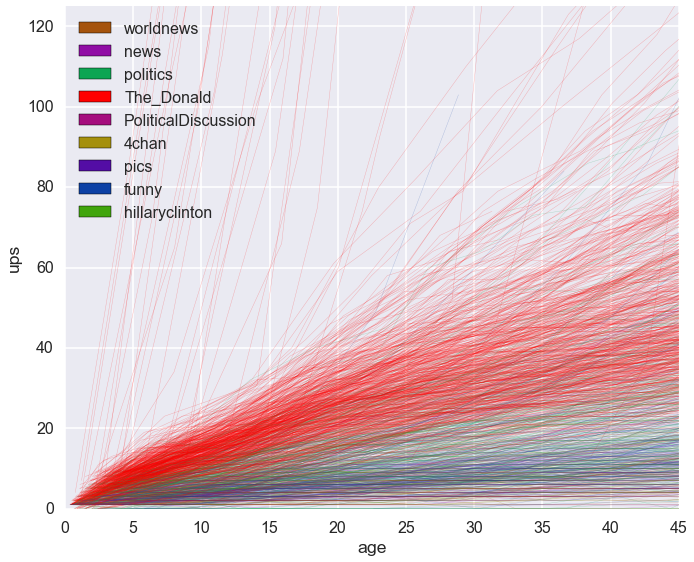

In [15]:
dfd = pd.DataFrame(dics)

fig,ax = plt.subplots(1,1,figsize=(11,9))
sub_legends = []
for idx,row in dfd.sample(len(dfd)).iterrows():
    if row['subreddit'] in subreddits:
        sdf = row['ts_scores']
        sdf = sdf.rename(columns={ycol:row['subreddit']})
        sdf.plot(x='total_mins',y=row['subreddit'], ax=ax, alpha=0.27, marker='',linewidth=0.43, color=row['color'])


ax.legend(recs,legend_names,loc='upper left')
        
plt.ylim([0,125])
plt.xlim([0,45])
plt.xlabel(xcol)
plt.ylabel(ycol)